<a href="https://colab.research.google.com/github/padmins/Rep_First/blob/master/Tabular_Playground_October.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Download Kaggle data to colab

In [2]:
! kaggle competitions download tabular-playground-series-oct-2021

 98% 860M/877M [00:05<00:00, 162MB/s]
100% 877M/877M [00:05<00:00, 169MB/s]
  0% 0.00/1.12M [00:00<?, ?B/s]
100% 1.12M/1.12M [00:00<00:00, 156MB/s]
 97% 424M/438M [00:02<00:00, 160MB/s]
100% 438M/438M [00:02<00:00, 170MB/s]


### Unzip Train , test and sample_submission file

In [3]:
! unzip train.csv.zip
! unzip test.csv.zip
! unzip sample_submission.csv.zip



Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


Import the necessary libraries


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,...,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,0.026177,0.106613,0.200924,0.713191,0.155750,0.557335,0.341702,0.285720,0.230396,0.203957,0.509588,0.706972,1,0.007793,0.247765,0.263750,0.259555,0.231730,0.138379,0.197824,0.054392,0.194153,0.281500,0.034818,0.025334,0.114432,0.139203,0.246157,0.251371,...,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1
1,1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,0.493411,0.107277,0.231828,0.457150,0.395200,0.617088,0.459358,0.209225,0.201098,0.199383,0.366578,0.585788,1,0.285311,0.400367,0.162493,0.249365,0.141160,0.133688,0.247906,0.139251,0.216444,0.109674,0.033018,0.017458,0.189336,0.168785,0.184251,0.202753,...,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1
2,2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,0.139532,0.107222,0.247791,0.631949,0.347463,0.642173,0.257763,0.162548,0.327377,0.193583,0.495440,0.636742,0,0.007133,0.309747,0.221081,0.284810,0.230828,0.138271,0.199742,0.060408,0.146746,0.208131,0.035977,0.022631,0.113542,0.274871,0.182770,0.151502,...,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1
3,3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,0.147122,0.105433,0.287755,0.455777,0.247971,0.616628,0.335907,0.337025,0.239127,0.176163,0.538269,0.706468,1,0.008829,0.353799,0.219977,0.266858,0.145617,0.138590,0.234925,0.059817,0.140886,0.205023,0.319312,0.009972,0.112291,0.288915,0.332632,0.140831,...,1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,0.260239,0.102561,0.265285,0.503776,0.269776,0.545945,0.319548,0.278538,0.214922,0.200239,0.534551,0.728652,0,0.004840,0.323546,0.166292,0.285516,0.208651,0.200394,0.198155,0.414729,0.251997,0.193405,0.034490,0.016465,0.197312,0.207429,0.255857,0.139875,...,0,0,0,1,1,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1


In [6]:
train_df.shape

(1000000, 287)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 287 entries, id to target
dtypes: float64(240), int64(47)
memory usage: 2.1 GB


In [8]:
all_data = train_df.drop(columns=['target','id'],axis=1)
all_data.shape

(1000000, 285)

In [9]:
all_target = train_df['target']

## Check the distribution of Target values

In [10]:
all_target.value_counts()

1    500485
0    499515
Name: target, dtype: int64

In [11]:
data_used = all_data[:800000]
labels_used= all_target[:800000]

In [12]:

from sklearn.model_selection import train_test_split

In [13]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data_used,labels_used,test_size=0.1)

In [14]:
train_data.shape, valid_data.shape, train_labels.shape, valid_labels.shape

((720000, 285), (80000, 285), (720000,), (80000,))

In [16]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators =100, max_leaf_nodes=16,random_state=42, max_features=5)
rnd_clf.fit(train_data,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
val_preds = rnd_clf.predict_proba(valid_data)

In [19]:
val_preds1 = rnd_clf.predict(valid_data)

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score,roc_auc_score
confusion_matrix(valid_labels,val_preds1)

array([[32169,  7861],
       [11484, 28486]])

Prediction of probabilities for ROC_AUC_Score

In [21]:
act_preds = val_preds[:,1] 

In [23]:
print(accuracy_score(valid_labels,val_preds1))
print(roc_auc_score(valid_labels,act_preds))

0.7581875
0.836055845281413


## Finding the top 10 important features

In [25]:
important_features_dict = {}
for idx, val in enumerate(rnd_clf.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'10 most important features: {important_features_list[:10]}')

10 most important features: [22, 179, 69, 136, 58, 156, 214, 78, 3, 12]


## Function to plot top 20 important features

In [26]:
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:20], y=fi_df['feature_names'][:20])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


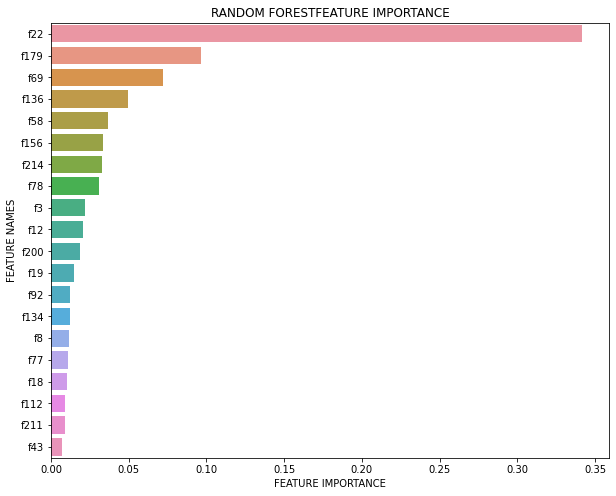

In [27]:
plot_feature_importance(rnd_clf.feature_importances_,all_data.columns,'RANDOM FOREST')

In [28]:
imp_features = ['f22','f179','f69','f58','f214','f136','f78','f156','f3','f77','f8','f92','f12','f43','f200','f247','f211','f112','f18','f134','f19']

### Considering only top 20 features for our training and evaluation

In [29]:
train_data_new = train_data[imp_features]
valid_data_new = valid_data[imp_features]

In [30]:
import random
random.seed = 42

### Try Logistic Regression Model with only important features and 0.8 million of data

In [32]:
from sklearn.linear_model import LogisticRegression

lr_new = LogisticRegression(solver='saga', penalty='l1', max_iter=50, random_state=42, C=0.001)
lr_new.fit(train_data_new,train_labels)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
val_preds = lr_new.predict_proba(valid_data_new)[:,1]

### keeping LR as our base model, compute roc_auc_score

In [35]:
print(roc_auc_score(valid_labels,val_preds))

0.8240333916437828


Predicting Random Forest Classifier ROC_AUC_Score using only important features

In [36]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf1 = RandomForestClassifier(n_estimators =120, max_leaf_nodes=16,random_state=42, max_features=5)
rnd_clf1.fit(train_data_new,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [37]:
y_preds1 = rnd_clf1.predict_proba(valid_data_new)[:,1]
print(roc_auc_score(valid_labels,y_preds1))

0.8281841233535694


### Trying DNN using Tensorflow - consider only Top 21 important features

In [38]:
import tensorflow as tf

from tensorflow import keras


In [48]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16,activation='selu', input_shape=(21,)))
model.add(tf.keras.layers.Dense(32,activation='selu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32,activation='selu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))


In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [50]:
model.fit(train_data_new,train_labels, batch_size=32, epochs=5,
          validation_data=(valid_data_new,valid_labels))


Epoch 1/5
22500/22500 [==============================] - 71s 3ms/step - loss: 0.5174 - accuracy: 0.7554 - val_loss: 0.5120 - val_accuracy: 0.7528
Epoch 2/5
22500/22500 [==============================] - 70s 3ms/step - loss: 0.5122 - accuracy: 0.7562 - val_loss: 0.5064 - val_accuracy: 0.7575
Epoch 3/5
22500/22500 [==============================] - 71s 3ms/step - loss: 0.5107 - accuracy: 0.7567 - val_loss: 0.5068 - val_accuracy: 0.7574
Epoch 4/5
22500/22500 [==============================] - 70s 3ms/step - loss: 0.5098 - accuracy: 0.7569 - val_loss: 0.5086 - val_accuracy: 0.7569
Epoch 5/5
22500/22500 [==============================] - 69s 3ms/step - loss: 0.5090 - accuracy: 0.7571 - val_loss: 0.5052 - val_accuracy: 0.7582


In [52]:
valid_preds = tf.squeeze(model.predict(valid_data_new))
print(roc_auc_score(valid_labels,valid_preds))

0.8316932290774413


## Trying with Gradient Boosting Decision Trees for classification

## you can observe that GBDT is slower as it is a sequentail process unlike Random forests

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100,
                                 min_samples_leaf=16,
                                 random_state=42,
                                 max_depth=5,
                                 learning_rate=0.1
                                 )
gbc.fit(train_data_new,train_labels)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=16, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [55]:
y_predictions=gbc.predict_proba(valid_data_new)[:,1]
print(roc_auc_score(valid_labels,y_predictions))

0.8411877075430856


In [ ]:
50,5,0.01 -> 0.8275602030555536
50,5,0.1, 32 -> 0.8371356121328695
50,5,1 -> 0.8304029061517143
50,5,0.3 -> 0.8365210774918708
50,7,0.1 -> 0.8369981705918417
100,5,0.2 -> 0.8369681624513573
50,9,0.1 -> 0.8360158545612544
50,5,0.1, 16 -> 0.8371562687392817
50, 7, 0.15,16 -> 0.8369343944899855
100,5,0.1,16 -> 0.8376441555183308
100,7,0.08,16-> 0.8368162266327451


## We can try Gri search for best Parameter values using the below code

In [99]:
parameters = {
    "n_estimators":[50,100],
    "max_depth":[3,5,7],
    "learning_rate":[0.01,0.1,0.3,1]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=3)
cv.fit(train_data_new,train_labels.values.ravel())

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
display(cv)

In [ ]:
### Read test data and take only important features for evaluation

In [57]:
test_df = pd.read_csv('test.csv')

In [58]:
test_df_modified = test_df[imp_features]

In [61]:
submission_df = pd.read_csv('sample_submission.csv')

In [63]:
y_preds_actual = gbc.predict_proba(test_df_modified)[:,1]

In [64]:
submission = pd.DataFrame({'id':submission_df['id'],'target':y_preds_actual})

In [65]:
y_preds_actual

array([0.73092465, 0.31536385, 0.89123483, ..., 0.50691906, 0.53214389,
       0.43690705])

In [66]:
submission_df.head()

,id,target
0,1000000,0.5
1,1000001,0.5
2,1000002,0.5
3,1000003,0.5
4,1000004,0.5


In [67]:
submission = pd.DataFrame({'id':submission_df['id'],'target':y_preds_actual})

In [68]:
submission

,id,target
0,1000000,0.730925
1,1000001,0.315364
2,1000002,0.891235
3,1000003,0.832761
4,1000004,0.223503
...,...,...
499995,1499995,0.965956
499996,1499996,0.633360
499997,1499997,0.506919
499998,1499998,0.532144


In [69]:
submission.to_csv('New_submission_18_oct.csv',index=False)